<a id='1lrskl'></a>
## 1. Contents of Logistic Regression Model with scikit-learn to predict Credit Card frauds or anomalies

* [2 About Dataset](#2lrskl)
* [3 Loading the dataset](#3lrskl)
* [4 Data Processing](#4lrskl)</br>
    [4.1 Creating "normal" and "anomaly" dataframes](#41lrskl)</br>
    [4.2 Splitting train, test and validate sets](#42lrskl)</br>
    [4.3 Rescaling or Standardizing the train, test and validate sets](#43lrskl)</br>
* [5 Model training](#5lrskl)</br>
* [6 Model Evaluation](#6lrskl)</br>
* [7 Model Validation](#7lrskl)</br>
    [7.1 Cross-Validation](#71lrskl)</br>
    [7.2 Benefits of Cross-Validation](#72lrskl)</br>
* [8 Ploting AUC and the Confusion Matrix](#8lrskl)</br>
* [References](#Reflrskl)</br>

In this notebook we will analyze the credit card data set in order to later build simple anomaly detection models.

data source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

<a id='2lrskl'></a>
## 2. About the program

### Context
This program is about in how to build a simple logistic regression model in scikit-learn, including the process of
k-fold cross validation to tune a hyperparameter in scikit-learn.

### Introduction
In the program "CredCardAnomDetect1.ipynb" was loaded and analyzed the distribution the credit card data.

There, we also looked at the relationships between the features (`Time`,`Amount`, `Class`, V1-v28) and got a general idea of how heavily they influence the labels (`Class` feature for Fraud=1 Normal=0).

Once have gained a better understanding of the data set, we'll proceed with building the models themselves using the same credit card data set as in the program "CredCardAnomDetect1.ipynb". In this program will look at scikit-learn framework. 

This model build in scikit-learn will stay relevant for the rest of the MLOps, as we will be using it them later on when we host them on cloud services to make predictions. We will be performing the validation step with the scikit-learn model
to tune a hyperparameter. Hyperparameters can be thought of as model-related parameters that influence the training process and result.

That being said, let’s get started with scikit-learn and build a logistic regression model. One thing to note is that we will provide a lot of commentary in the scikit-learn model that we may skip over in the PySpark example, so be sure to at least read through the process for scikit-learn to get a general idea of how train-test-validate works.

[Return to Contents of credit card dataset analysis](#1lrskl)

## 3. Loading the dataset
<a id='3cca'></a>

In the code below, you will find that some of the imports are unnecessary, such as importing all of sklearn when you only use a bit of its functionality. This is done for the purpose of displaying the version.

In [1]:
import numpy as np #Version: 1.21.5
import pandas as pd #version 1.3.5
import matplotlib.pyplot as plt #matplotlib version 3.5.1
from pylab import rcParams
rcParams['figure.figsize'] = 14,8 
%matplotlib inline
#Python version 3.7.13

import seaborn as sns # version 0.11.2
import sklearn # version 1.0.2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import KFold

print("seaborn: {}".format(sns.__version__))
print("sklearn: {}".format(sklearn.__version__))

seaborn: 0.11.2
sklearn: 1.0.2


In [2]:
cc = pd.read_csv("creditcard.csv")

In [3]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
cc.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The main takeaways here are:
1. there are a huge number of data points.
2. There are 284,807 rows and 31 columns in this data frame. 
> That’s a lotof entries! Theres is a wide range of values for Time and Amount.
>> So when building the various data sets for the model training process, we definitely need to scale down the data. Otherwise, such **large data values can potentially mess up the training process**.

3. There is a massive **imbalance in the distribution of data between the normal data and the anomalies**. Because of this, we are going to take a slightly alternative approach in how you craft this data.

[Return to Contents of credit card dataset analysis](#1lrskl)

## 4 Data Processing
<a id='4lrskl'></a>

<a id='41lrskl'></a>
### 4.1 Creating "normal" and "anomaly" dataframes

This is where data analysis comes into play. Because you know that a massive disparity between the data counts in each class exists, you will now take care to specially craft the data sets so that it is ensured that a good amount of anomalies end up in each data set. 

If we simply select 100,000 data points from "cc", split it into training / test / validate sets and continue, it is entirely possible that very few or even no anomalies end up in one or more of those sets. Then at that point, we would have a lot of trouble in getting the model to properly learn this task.

In [5]:
print(f"Number of Anomalies records:{cc[cc.Class == 1].shape}")
print(f"Number of Normal records:{cc[cc.Class == 0].shape}")

Number of Anomalies records:(492, 31)
Number of Normal records:(284315, 31)


With that in mind, let’s create data frames for the normal points and for the fraudulent points. In the following cell's code, we filter out the respective values by class, and sample 50% of the entire data frame’s normal points to comprise the normal data in this context. 

The "normal" set will contain half (`frac=0.5`) of original records, randomly selected (`random_state=2020`). This new 'normal' set has top have its own new index, so we have to reset its index (`reset_index(drop=True`).

By seting the random_state to a specific value, the results of the random sampling should be the same no matter how many times you repeat it, helping with reproducibility. Unfortunately, given the nature of how models learn, you cannot expect to get the same results every time for something like neural networks, for example.

In [6]:
normal = cc[cc.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = cc[cc.Class == 1]

In [7]:
print(f"Number of Anomalies records:{anomaly[anomaly.Class == 1].shape}")
print(f"Number of Normal records:{normal[normal.Class == 0].shape}")

Number of Anomalies records:(492, 31)
Number of Normal records:(142158, 31)


As we can see, there is still a big disparity between the normal points and the anomalies. <span style='background :lightgreen'>In the case of **logistic regression**, the model is still able to learn how to distinguish between the two, but in the case of **neural networks**, for example, this disparity means the model never really learns how to classify anomalies.</span> However, as we will see later we can tell the model to weigh the anomalies far more in its learning process compared to the normal points.

In [8]:
normal.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,133857.0,2.187805,-1.611486,-1.440886,-1.993565,-0.242212,1.452343,-1.471309,0.461035,-1.289404,...,-0.101115,0.216152,0.266066,-0.995196,-0.341845,-0.075408,0.041265,-0.074721,15.00,0
1,149981.0,-0.588450,0.638268,0.077929,-2.016587,0.263760,-0.712403,0.438756,0.161525,-1.701463,...,-0.066238,0.183698,-0.372989,-0.730899,0.184996,0.749913,-0.070820,0.043069,3.95,0
2,72742.0,-0.955411,0.468744,1.472644,-0.426779,0.935434,-0.879686,0.407897,0.097877,-0.733877,...,-0.129510,-0.657881,-0.039850,-0.053269,-0.134374,-0.045296,0.021703,0.113690,1.79,0


In [9]:
anomaly.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1


[Return to Contents of credit card dataset analysis](#1lrskl)

<a id='42lrskl'></a>
### 4.2 Splitting train, test and validate sets

Normally the scikitlearn `train_test_split` it is code like: 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 2020)

bein y sets for the labels

Now you can start creating the **train/test/validate** split (3 datasets). However, scikitlearn provides functionality to create **train/test** splits only (2 datasets). To get around that (that restriction), you will create **train and test** sets, and then split the **train set** again into **train and validate** sets.

First, you will split the data into train and test data, keeping the normal points and anomalies separate. To do this, you will use the `train_test_split()` function from scikit-learn. Commonly passed parameters are
> x: The x set you want to split up

> y: The y set you want to split up corresponding to the x set

> test_size: The proportion of data in x and y that you want to randomly sample for the test set.

In [10]:
normal_train, normal_test = train_test_split(normal, test_size = 0.2,
                                             random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly,test_size = 0.2,
                                               random_state = 2020)

In [11]:
print(f"Number of 'normal_train' records:{normal_train.shape}")
print(f"Number of 'normal_test' records:{normal_test.shape}")

Number of 'normal_train' records:(113726, 31)
Number of 'normal_test' records:(28432, 31)


In [12]:
print(f"Number of 'anomaly_train' records:{anomaly_train.shape}")
print(f"Number of 'anomaly_test' records:{anomaly_test.shape}")

Number of 'anomaly_train' records:(393, 31)
Number of 'anomaly_test' records:(99, 31)


Now, we can create our **training and validation sets** by calling the
same function on the respective training sets. 

You don’t want to split it by 20% again, though, since the training set is already 80% of the original data set. If you used a 20% split again, the validation set would be 16% of the original data, and the training set would be 64% of the original data.

You will instead be doing a 60-20-20 split for the training, testing, and validation data, respectively, and so you will be using a new test_size
value of 0.25 to ensure these proportions hold (0.25 * 0.8 = 0.2).

In [13]:
normal_train, normal_validate = train_test_split(normal_train, 
                                                 test_size = 0.25,
                                                 random_state = 2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train,
                                                   test_size = 0.25,
                                                   random_state = 2020)

In [14]:
print(f"Number of 'normal_train' records:{normal_train.shape}")
print(f"Number of 'normal_test' records:{normal_test.shape}")
print(f"Number of 'normal_validate' records:{normal_validate.shape}")
print(f"Number of 'anomaly_train' records:{anomaly_train.shape}")
print(f"Number of 'anomaly_test' records:{anomaly_test.shape}")
print(f"Number of 'anomaly_validate' records:{anomaly_validate.shape}")

Number of 'normal_train' records:(85294, 31)
Number of 'normal_test' records:(28432, 31)
Number of 'normal_validate' records:(28432, 31)
Number of 'anomaly_train' records:(294, 31)
Number of 'anomaly_test' records:(99, 31)
Number of 'anomaly_validate' records:(99, 31)


In [15]:
normal_train.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
73530,34352.0,0.625714,-0.756745,-0.207026,1.573003,-0.430353,-0.324872,0.507153,-0.071852,0.286757,...,0.150580,-0.127345,-0.355638,0.068798,0.597708,-0.256959,-0.041794,0.057961,298.4,0
10844,37979.0,-3.599816,2.854945,0.122647,-0.650653,-0.210900,0.036756,0.466738,0.045659,2.342779,...,-0.425969,-0.501651,-0.036863,-0.475188,0.432695,0.271133,0.504334,0.954164,9.1,0


In [16]:
normal_test.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
88886,87757.0,-2.328666,2.182930,-1.169306,-3.124697,0.540151,-0.345266,0.425654,0.943126,0.449079,...,-0.366215,-0.993131,-0.064021,-0.357845,0.357530,0.411029,0.495000,0.328720,5.0,0
26012,91291.0,-0.783699,1.045875,1.244223,-0.591064,1.093158,-0.931364,1.072304,-0.324102,0.576050,...,0.142624,0.627911,-0.537658,1.151134,1.054627,-0.087460,-0.027067,0.052886,2.3,0


In [17]:
normal_validate.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
35923,31391.0,0.971094,-0.648701,1.045878,0.500264,-1.220093,-0.283541,-0.428240,-0.016497,0.995747,...,-0.149829,-0.411447,-0.035906,0.497161,0.123308,0.894448,-0.049118,0.038217,130.0,0
70127,117084.0,1.046873,-1.816050,-2.608729,0.131919,0.796255,1.276401,0.617104,0.146024,0.098783,...,0.426441,0.279770,-0.315463,-0.869219,-0.240134,0.726296,-0.157260,-0.012268,490.0,0


To create the final training, testing, and validation sets, we have to concatenate the respective normal and anomaly data splits.

First, lets define x_train, x_test, and x_validate:

In [18]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

In [19]:
print(f"Number of 'x_train' records:{x_train.shape}")
print(f"Number of 'x_test' records:{x_test.shape}")
print(f"Number of 'x_validate' records:{x_validate.shape}")

Number of 'x_train' records:(85588, 31)
Number of 'x_test' records:(28531, 31)
Number of 'x_validate' records:(28531, 31)


Next, **define y_train, y_test, and y_validate**(target values):

In [20]:
y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

In [21]:
print(f"Number of 'y_train' records:{y_train.shape}")
print(f"Number of 'y_test' records:{y_test.shape}")
print(f"Number of 'y_validate' records:{y_validate.shape}")

Number of 'y_train' records:(85588,)
Number of 'y_test' records:(28531,)
Number of 'y_validate' records:(28531,)


In [22]:
y_train[0:3]

array([0, 0, 0], dtype=int64)

In [23]:
y_train[-3:]

array([1, 1, 1], dtype=int64)

Seems that last rows contain the anomalies labels

In [24]:
x_train.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
73530,34352.0,0.625714,-0.756745,-0.207026,1.573003,-0.430353,-0.324872,0.507153,-0.071852,0.286757,...,0.150580,-0.127345,-0.355638,0.068798,0.597708,-0.256959,-0.041794,0.057961,298.4,0
10844,37979.0,-3.599816,2.854945,0.122647,-0.650653,-0.210900,0.036756,0.466738,0.045659,2.342779,...,-0.425969,-0.501651,-0.036863,-0.475188,0.432695,0.271133,0.504334,0.954164,9.1,0


**Finally**, we have to drop the column `Class` in the x sets since it would  defeat the purpose of teaching the model how to learn what makes up a normal and a fraudulent transaction if you gave it the label directly.

In [25]:
x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

In [26]:
x_train.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
73530,34352.0,0.625714,-0.756745,-0.207026,1.573003,-0.430353,-0.324872,0.507153,-0.071852,0.286757,...,0.286965,0.150580,-0.127345,-0.355638,0.068798,0.597708,-0.256959,-0.041794,0.057961,298.4
10844,37979.0,-3.599816,2.854945,0.122647,-0.650653,-0.210900,0.036756,0.466738,0.045659,2.342779,...,1.162696,-0.425969,-0.501651,-0.036863,-0.475188,0.432695,0.271133,0.504334,0.954164,9.1


In [27]:
print(f"Number of 'x_train' records:{x_train.shape}")
print(f"Number of 'y_train' records:{y_train.shape}")
print(f"Number of 'x_test' records:{x_test.shape}")
print(f"Number of 'y_test' records:{y_test.shape}")
print(f"Number of 'x_validate' records:{x_validate.shape}")
print(f"Number of 'y_validate' records:{y_validate.shape}")

Number of 'x_train' records:(85588, 30)
Number of 'y_train' records:(85588,)
Number of 'x_test' records:(28531, 30)
Number of 'y_test' records:(28531,)
Number of 'x_validate' records:(28531, 30)
Number of 'y_validate' records:(28531,)


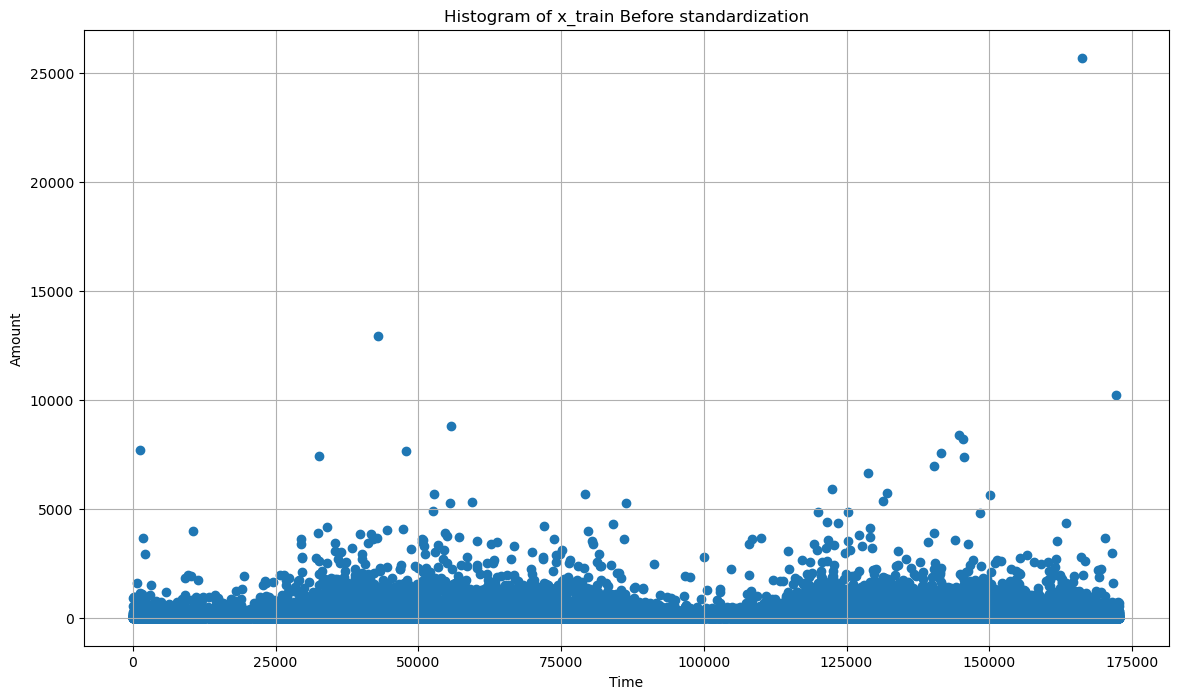

In [28]:
plt.scatter(x_train.Time,x_train.Amount)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Histogram of x_train Before standardization')
plt.grid(True)

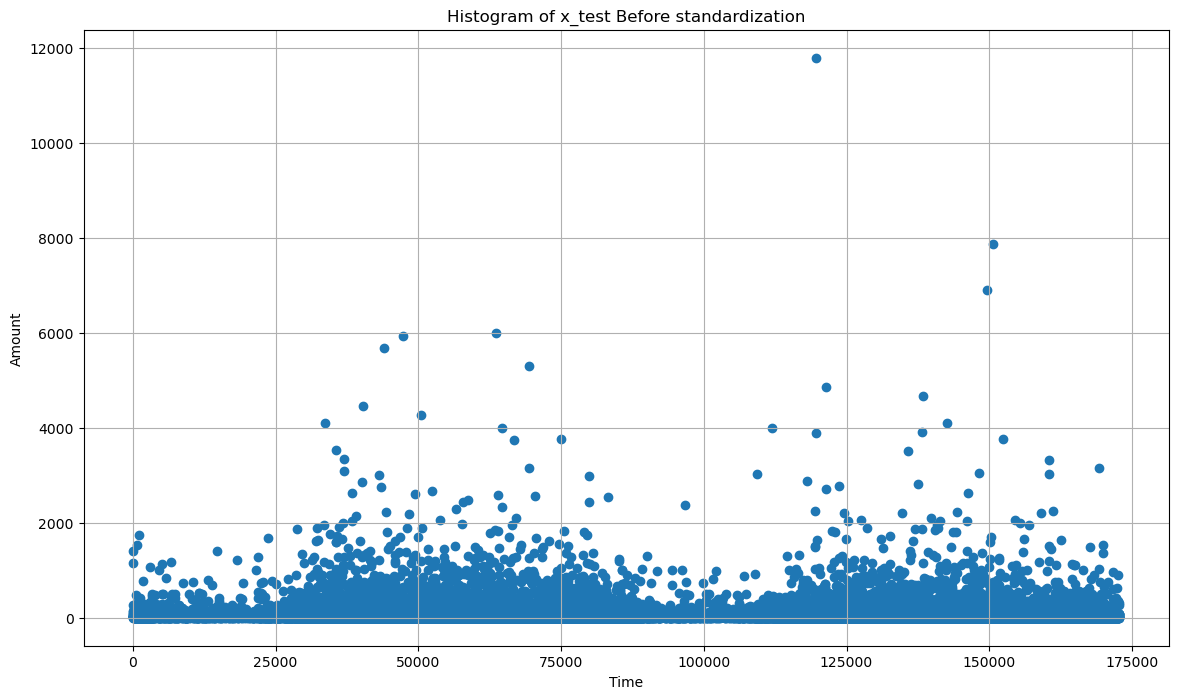

In [29]:
plt.scatter(x_test.Time,x_test.Amount)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Histogram of x_test Before standardization')
plt.grid(True)

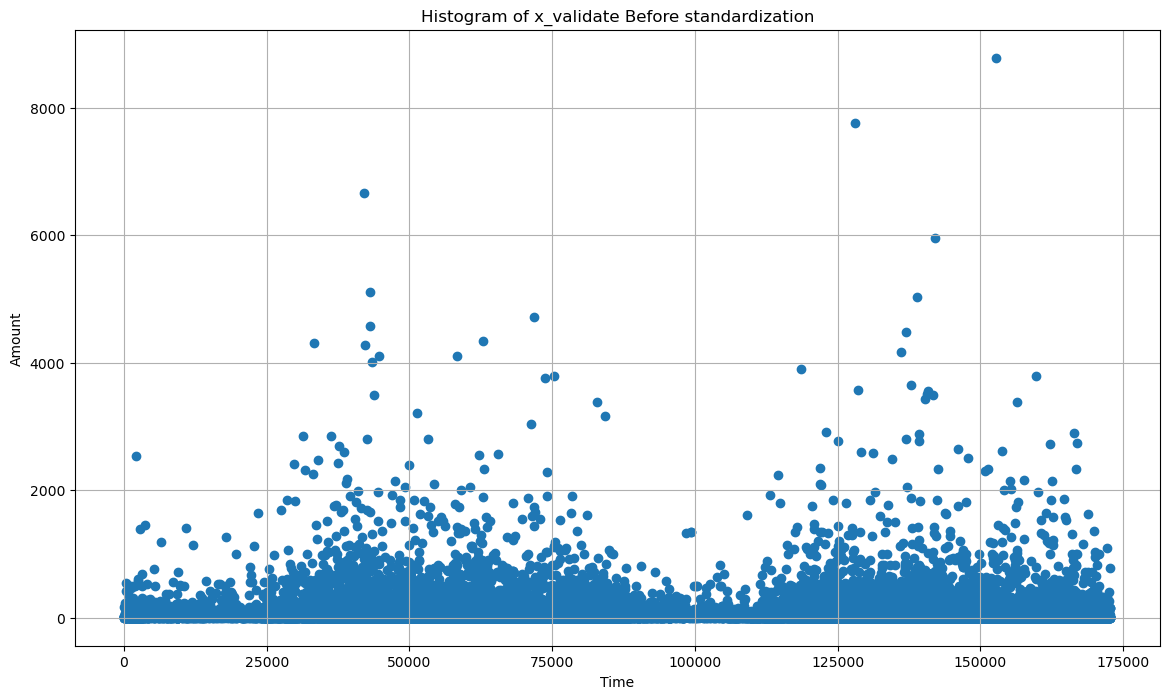

In [30]:
plt.scatter(x_validate.Time,x_validate.Amount)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Histogram of x_validate Before standardization')
plt.grid(True)

[Return to Contents of credit card dataset analysis](#1lrskl)

<a id='43lrskl'></a>
### 4.3 Feature scaling for train, test and validate sets

The following paragraphs taken from (Gupta & Sehgal, 2021) provides proper context about scales:
    
When data has attributes with varying scales, it may be helpful to **rescale**. Many machine learning algorithms can benefit from **rescaling the attributes to all have the same scale**.

**Feature scaling** is an important step in the data transformation stage of the data preparation process. Feature scaling is the method to limit the range of variables so that they can be compared on common grounds. **Feature scaling is a method for standardization** of independent features. It means to adjust values of numeric features measured on different scales to **a notionally common scale, without altering differences in the value’s ranges or losing information**.

The goal is to improve the overall quality of the dataset by re-scaling the dimension of the data and avoiding situations in which some values over-weighting others.

By looking at the features and data analysis from the program "CredCardAnomDetect1.ipynb" we notice that some of the values get really large. 
When some features have a relatively small range but others have an extremely large range (think of the range of Time, V1 and Amount), the model will have a much harder time learning.

In [31]:
x_train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,85588.000000,85588.000000,85588.000000,85588.000000,85588.000000,85588.000000,85588.000000,85588.000000,85588.000000,85588.000000,...,85588.000000,85588.000000,85588.000000,85588.000000,85588.000000,85588.000000,85588.000000,85588.000000,85588.000000,85588.000000
mean,94703.479869,-0.000595,0.010506,-0.015631,0.006315,-0.011167,-0.005437,-0.003523,-0.002150,-0.006515,...,0.002747,-0.000067,0.004123,0.000550,0.002350,-0.001100,0.001531,-0.000877,-0.001305,89.086542
std,47535.293660,1.948894,1.625490,1.571524,1.429872,1.451552,1.350753,1.349201,1.221328,1.104254,...,0.759651,0.743845,0.727328,0.615677,0.605129,0.522579,0.482559,0.413684,0.309251,262.739468
min,0.000000,-41.928738,-50.383269,-48.325589,-5.683171,-113.743307,-19.996349,-37.060311,-39.267378,-11.126624,...,-54.497720,-21.620120,-8.887017,-30.269720,-2.822384,-6.429334,-1.855355,-9.895244,-15.430084,0.000000
25%,54041.000000,-0.924721,-0.599885,-0.900112,-0.847295,-0.693850,-0.772696,-0.549747,-0.209350,-0.648843,...,-0.211517,-0.227051,-0.540452,-0.160254,-0.353128,-0.319083,-0.325617,-0.071514,-0.053194,5.500000
50%,84591.500000,0.016339,0.067136,0.174318,-0.019377,-0.059915,-0.277441,0.040216,0.022028,-0.052724,...,-0.062786,-0.029594,0.011796,-0.010358,0.042608,0.017063,-0.050249,0.000848,0.011158,22.000000
75%,139312.000000,1.314743,0.805627,1.024513,0.746095,0.610188,0.395520,0.567690,0.326785,0.595050,...,0.134255,0.188460,0.532686,0.147504,0.441898,0.350302,0.243001,0.090447,0.077917,77.972500
max,172792.000000,2.451888,19.167239,4.226108,15.304184,28.762671,73.301626,120.589494,20.007208,10.392889,...,26.237391,27.202839,6.790452,22.528412,4.584549,5.525093,3.463246,31.612198,16.129609,25691.160000


In more detail, the model will have a hard time optimizing the cost function and may take many more steps to converge, if it is able to do so at all. And so it is better to scale everything down by **normalizing the data**.

The two most popular techniques of Feature Scaling are (Gupta & Sehgal, 2021):
1. Standardization
2. Normalization

**Standardizing**, a dataset involves rescaling the distribution of values so that the **mean** of observed values is **0** and the **standard deviation is 1**.  This can be thought of as subtracting the mean or **centering the data**.

**Standardization** assumes that observations fit a **Gaussian** distribution (bell curve) with a well-behaved mean and standard deviation. It requires that we know or are able to accurately estimate the mean and standard deviation of observable values.

One may be able to estimate these values from training data, not the entire dataset
(Gupta & Sehgal, 2021).

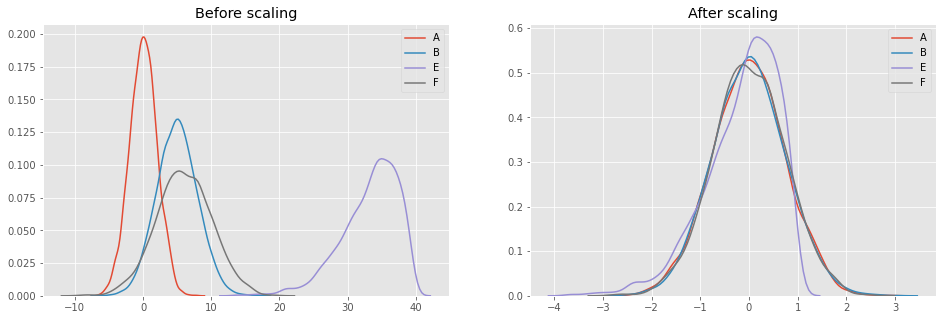
source:https://towardsdatascience.com/preprocessing-data-feature-scaling-cc28c508e8af

**Normalization (Min–Max Normalization)**
Normalization refers to rescaling the feature between min and max (usually between 0 and 1). To normalize the feature, subtract the min value from each feature instance and divide by the range of the feature (max–min) (Gupta & Sehgal, 2021).

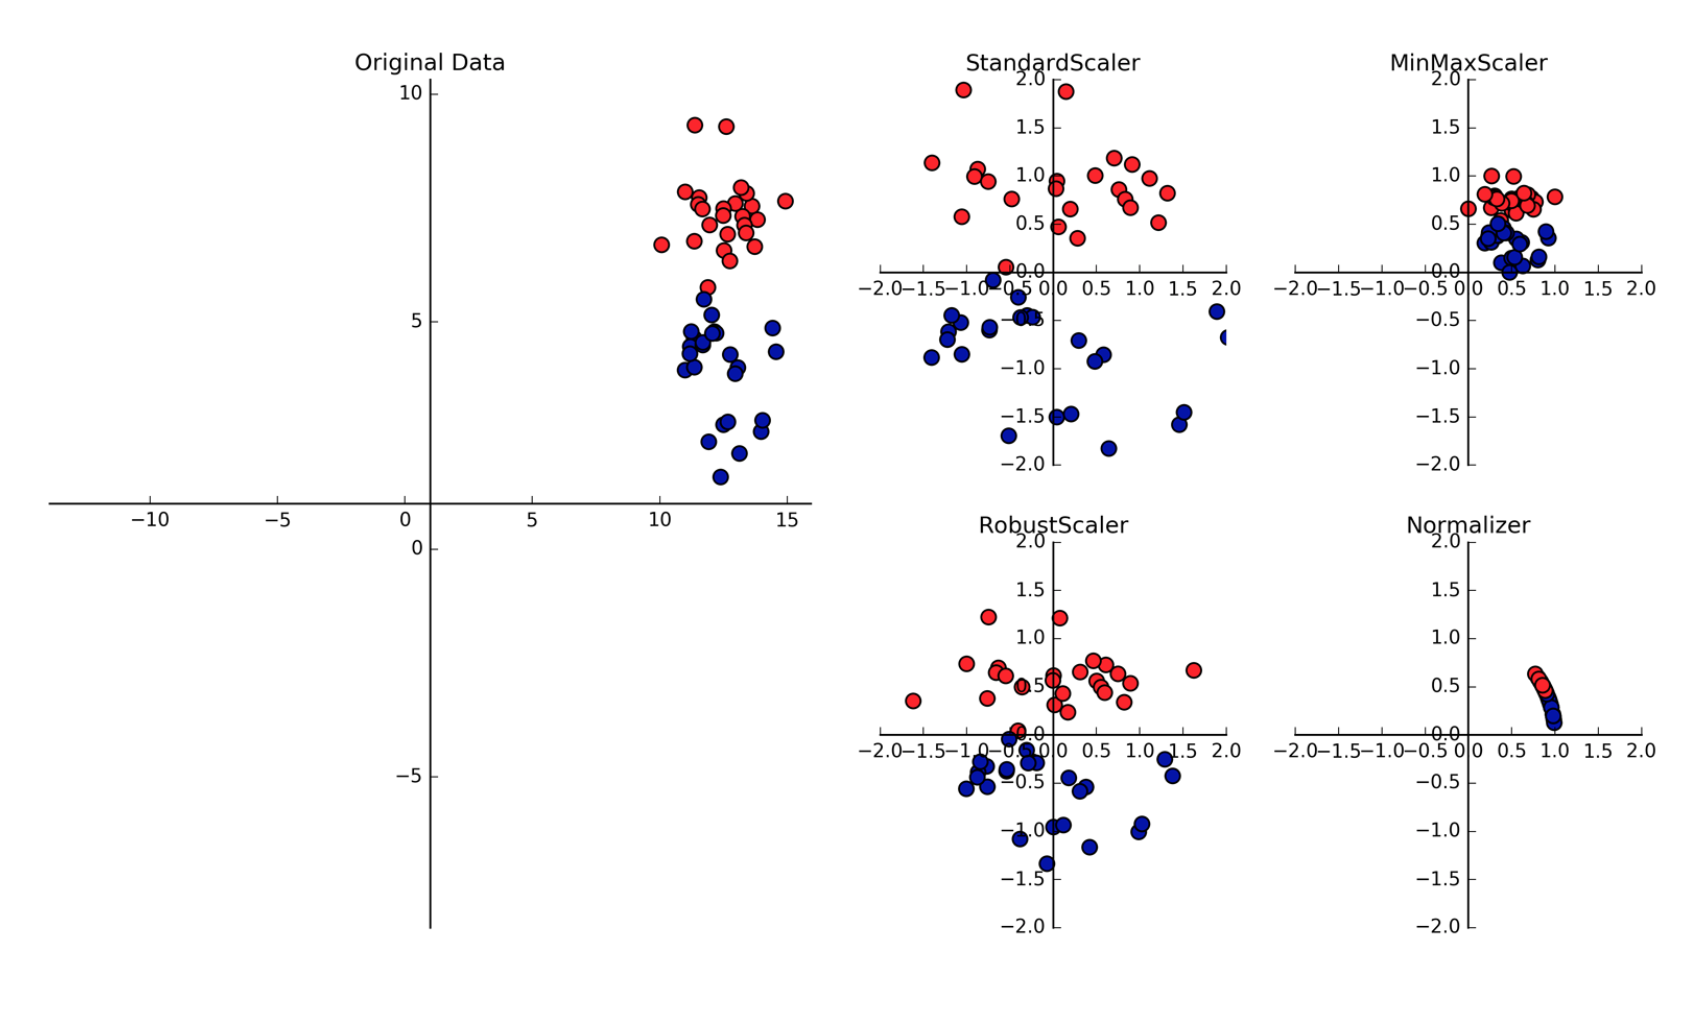

**Normalization** is another important concept needed to change all features to the same scale. This allows for **faster convergence on learning, and more uniform influence for all weights**.

**Tree-based models** are not dependent on scaling, but non-tree models models, very often are hugely dependent on it.

Outliers can affect certain scalers, and it is important to either remove them or choose a scalar that is robust towards them.

Fuente: https://python-data-science.readthedocs.io/en/latest/normalisation.html

We will be using **scikit-learn’s StandardScaler**, which normalizes all of the data such that the mean is 0 and the standard deviation is 1.

It is important to note that we are fitting the scaler on the entire data frame so that it standardizes all of your data in the same way. This is to ensure the best results since you don’t want to standardize x_train, x_test, and x_validate in their own ways since it would create discrepancies in the data and would be problematic for the model.

<span style='background :lightgreen'>Of course, **once you’ve deployed the model and start receiving new data**, you would still standardize it using the scaler from the training process, but this new data could possibly come from a slightly different distribution than your training data.</span>

<span style='background :beige'> This would especially be the case if trends start shifting -this new standardized data could possibly lead to a tougher time for the model since it wouldn’t fit very well in the distribution that the model trained on.</span>

In [32]:
scaler = StandardScaler() #creates an instance of StandardScaler
# trains the scaler by fitting on the entire dataframe
# so that it standardizes all of your data in the same way. 
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))

# applies the scaler to each "x" set to ensure the best results
# since you don’t want to standardize x_train, x_test, and x_validate 
# in their own ways since it would create discrepancies in 
# the data and would be problematic for the model. 
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

In [33]:
type(x_train)

numpy.ndarray

In [34]:
print(x_train.shape)

(85588, 30)


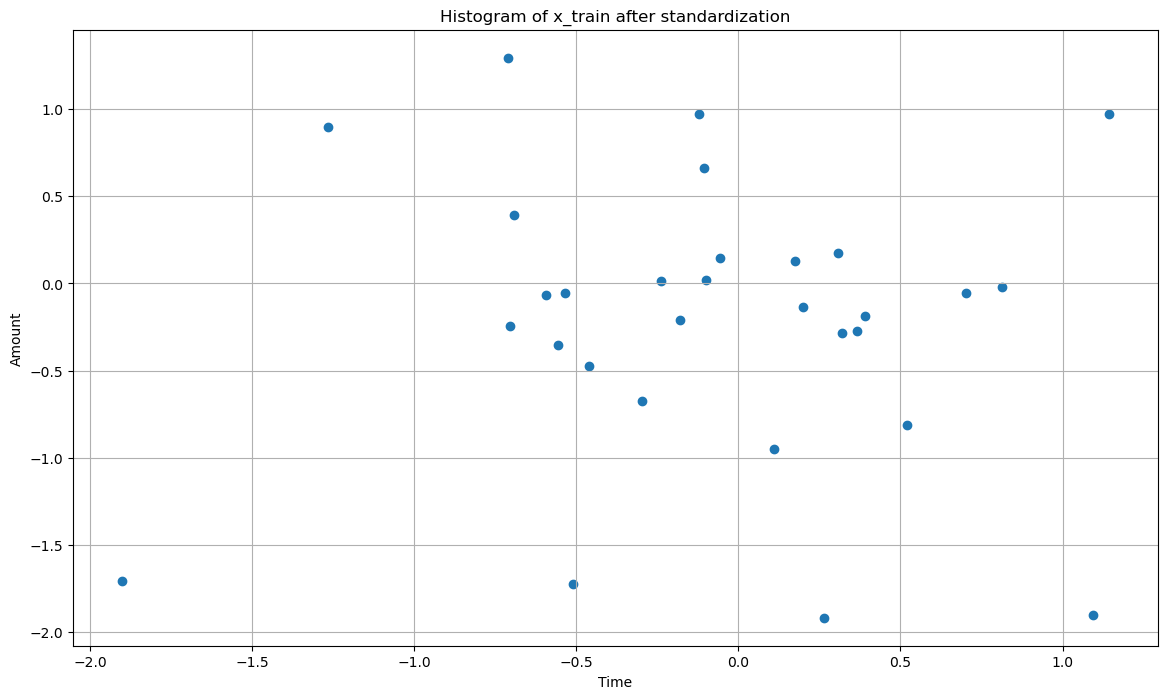

In [35]:
plt.scatter(x_train[0],x_train[30])
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Histogram of x_train after standardization')
plt.grid(True)

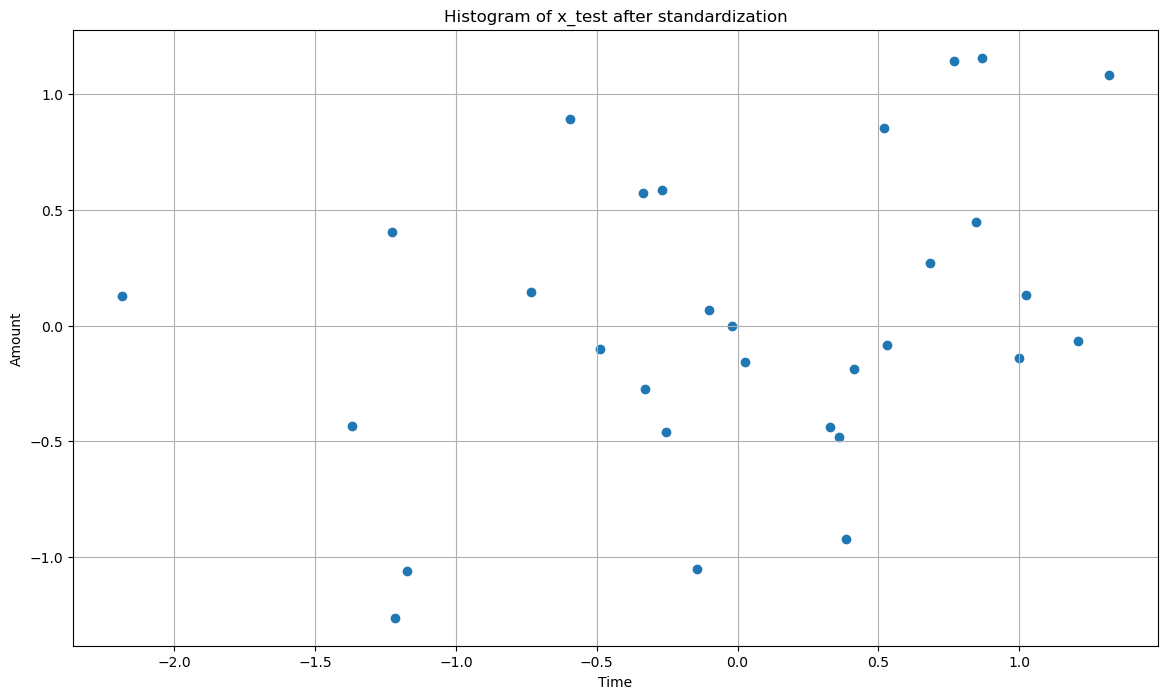

In [36]:
plt.scatter(x_test[0],x_test[30])
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Histogram of x_test after standardization')
plt.grid(True)

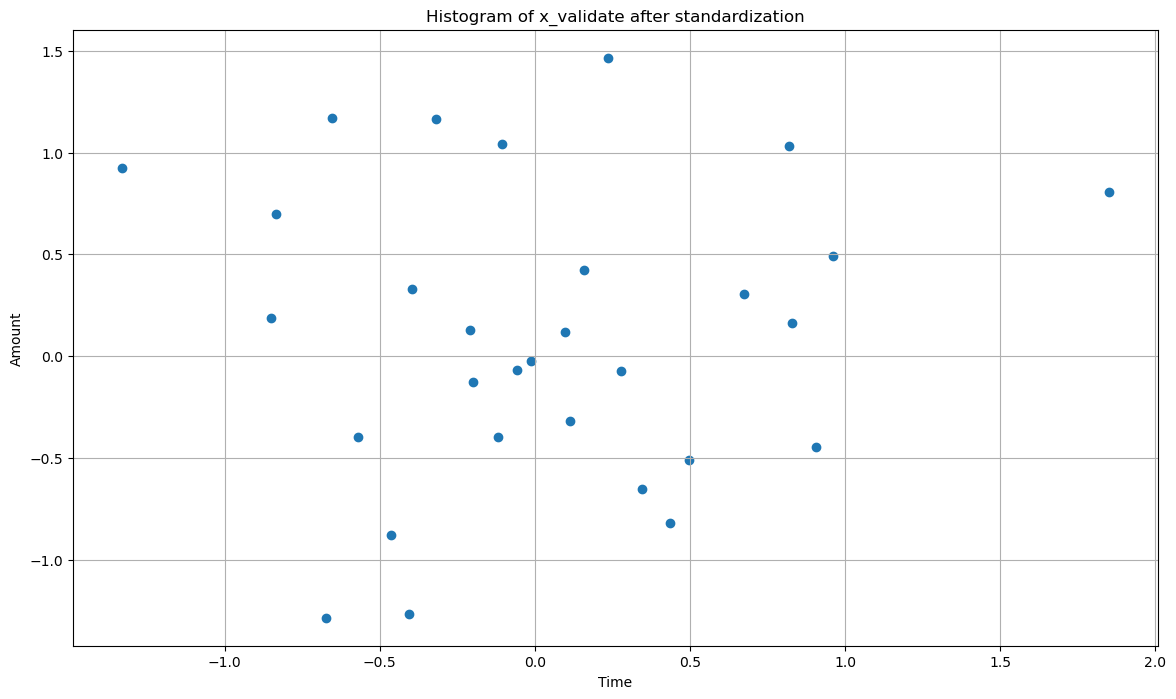

In [37]:
plt.scatter(x_validate[0],x_validate[30])
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Histogram of x_validate after standardization')
plt.grid(True)

[Return to Contents of credit card dataset analysis](#1lrskl)

<a id='5lrskl'></a>
### 5 Model training

Finally, we can now define our scikit logistic regression model:

In [38]:
sklr_model = LogisticRegression(random_state=None, max_iter=400,
                                solver='newton-cg').fit(x_train, y_train)

Modeling is the fourth phase of the CRISP-DM process model (Sarkar et. al., 2018).

The fourth phase in the CRISP-DM process is the core phase in the process where most of the analysis takes place with regard to using clean, formatted data and its attributes to build models to solve business problems. The CRISP-DM model and each of their phases are iterative process. So, the basic idea of the modeling phase is to build multiple models iteratively trying to get to the best model that satisfies our success criteria, data mining objectives, and business objectives. 

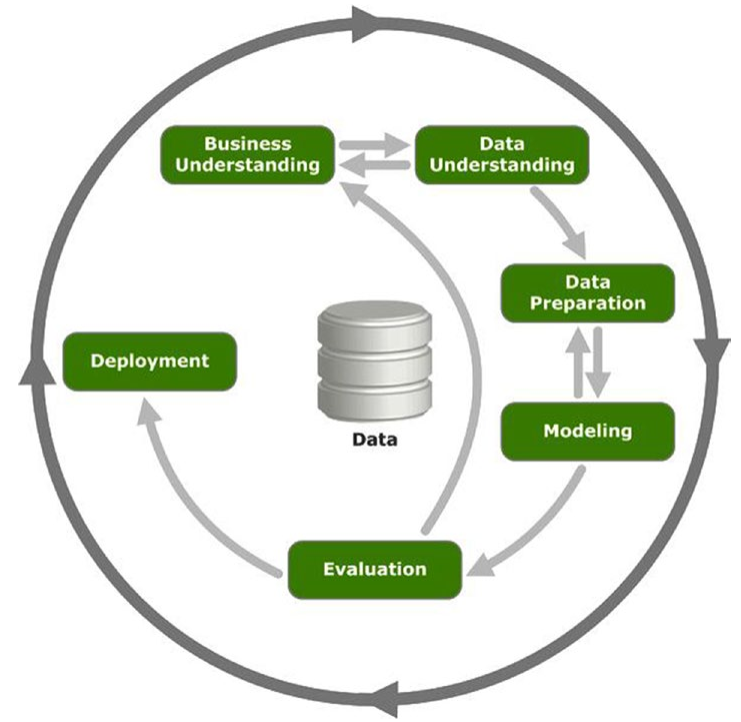</br> Figure 1. The six phases of data mining lifecycle with the CRISP-DM model.

There are 4  most common subprocess of the modeling phase (Sarkar et. al., 2018):

>1. Selecting Modeling Techniques. 
>> In this stage, we pick up a list of relevant Machine Learning and data mining tools, frameworks, techniques,
and algorithms listed in the “Business Understanding” phase. Techniques that are proven to be robust and useful in solving the problem are usually selected based on inputs and insights from data analysts and data scientists. These are mainly decided by the current data available, business goals, data mining goals, algorithm requirements, and constraints.

> 2. Model Building

>> The process of model building is also known as **training the model** using data and features from our dataset.
A combination of data (features) and Machine Learning algorithms together give us a model that tries to generalize on the training data and give necessary results in the form of insights and/or predictions.

>> Generally various algorithms are used to try out multiple modeling approaches on the same data to solve the same problem to get the best model that performs and gives outputs that are the closest to the business success criteria. 

According to (Verdhan, 2020) In general business practice, we compare accuracies of four or five algorithms and select the best ML model to implement in production.

>> Key things to keep track here are the models created, model parameters being used, and their results.

> 3. Model Evaluation and Tuning.
>>In this stage, we evaluate each model based on **several metrics like model accuracy, precision, recall, F1 score**, and so on. We also tune the model parameters based on techniques like **grid search and cross validation** to get to the model that gives us the best results. Tuned models are also matched with the data mining goals to see if we are able to get the desired results as well as performance. 

Model tuning is also termed as hyperparameter optimization in the Machine Learning world.

> 4. Model Assessment
>> Once we have models that are providing desirable and relevant results, a detailed assessment of the model is
performed based on the following parameters.
>>> Model performance is in line with defined success criteria

>>> Reproducible and consistent results from models

>>> Scalability, robustness, and ease of deployment

>>> Future extensibility of the model

After the training process, either **the evaluation** step or **validation** step can come next. As long as the testing set and the validation set come from different distributions (the **validation** set is derived from the training set, while the testing set is derived from the original data), the model is technically seeing new data in the **evaluation** and in the **validation** processes.

The context also matters. If you are using the **validation** process to select the best model out of a set of trained models, then the **validation** process can come after the training process. You can still **evaluate** one or all of your trained models, but it could be unnecessary because in this context you’re trying to find the best model for the code.

In the context where you’re trying to tune your **hyperparameters** for a model you are going to stick with, it doesn’t matter whether you do the evaluation first or the validation first. 

Doing the **evaluation** first, as you will be doing shortly, can give you a good idea of how well the model is doing currently before starting the **validation** step. The model will never learn from the evaluation data, so there’s no harm in evaluating the model on this data.

In this example, you are looking at **tuning the hyperparameter for class weights** (how much to weight a normal sample and how much to weight a fraudulent sample).

But first, let’s evaluate your model to get a deeper understanding of how everything works.

[Return to Contents of credit card dataset analysis](#1lrskl)

<a id='6lrskl'></a>
### 6 Model Evaluation

You can now look at **accuracy and AUC scores**. First, you find the accuracy using the built-in score function of the model:

In [39]:
eval_acc_sklr_model = sklr_model.score(x_test, y_test)
print(f"Eval Accuracy: {eval_acc_sklr_model:.3%}")

Eval Accuracy: 99.867%


In this case, normal points far outnumber anomalies, so accuracy is a relatively poor metric to solely judge model performance on. The problem with accuracy in this context is that if there are 100,000 normal points and perhaps around 100 anomalies, the model can classify all of the normal points correctly and none of the anomalies and still get a really high accuracy above 99%. However, the AUC score would show a value much lower at around 0.5.<span style='background:lightblue'> An AUC of 0.5 means that the model knows nothing and is practically just guessing randomly, but in this case, it means the model only ever predicts “normal” for any point it sees</span>. In other words, it hasn’t actually learned much of anything if it doesn’t know how to predict an anomaly.

Next, let’s get the list of **predictions** from the model to help calculate the **AUC score**.<span style='background:cyan'> AUC is usually a better metric since it better explains the **performance of the model**</span>. The general gist of it is that a model that perfectly classifies every point correctly will have an AUC score of 100%. 

In [40]:
preds_sklr_model = sklr_model.predict(x_test)

In [41]:
auc_score_sklr_model = roc_auc_score(y_test, preds_sklr_model )
print(f"Auc Score: {auc_score_sklr_model:.3%}")

Auc Score: 84.331%


In this case, both the AUC score and the accuracy score are high.
Between the two, the accuracy score is definitely inflated by the number of normal points that exist, but the AUC score indicates that the model does a pretty good job at distinguishing between the anomalies and the normal points.

It’s also worth mentioning that AUC isn’t the sole metric by which one should base the worthiness of a model, since context matters. AUC scores in this case would reflect the mode’s performance well, but it’s also possible to get higher AUC scores but lower accuracy scores. 

That just means you must look at the results carefully to understand exactly what’s happening. To help with this, you will look at a “confusion matrix” shortly. Scikit-learn actually provides a function that lets you see the ROC curve —the figure from which the AUC score (or “area under curve”) is derived from. Run the following:

C:\Users\conza\Anaconda3\envs\TFKERAS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


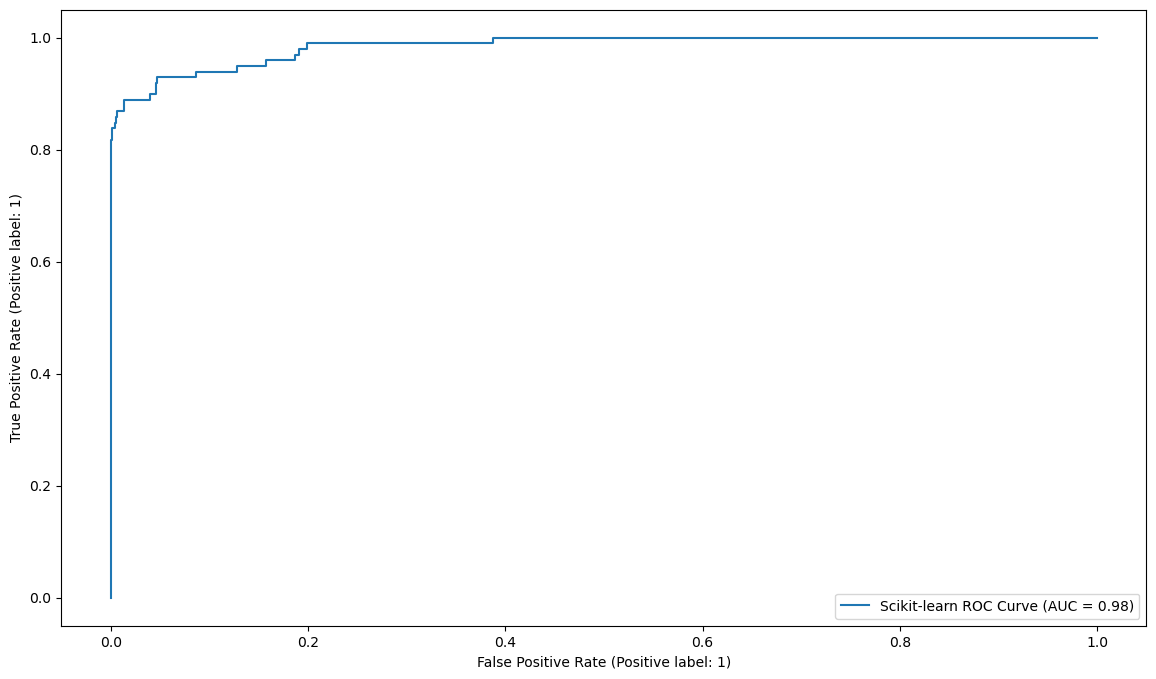

In [42]:
roc_plot_sklr_model = plot_roc_curve(sklr_model, x_test, y_test,
                                     name='Scikit-learn ROC Curve')

An ROC curve starting with a true positive value of 1.0 at a false positive value of 0.0 is the best possible curve in theory. From that point, it should keep going right while maintaining its value as it hits 1.0 on the x-axis. This graph is quite close to that ideal, hence why the AUC score is so high at 0.98. The discrepancy in AUC score here compared to when you calculated it earlier has to do with how the value is actually calculated

The **Receiver Operating Characteristics curve, or ROC curve** for short considers all possible thresholds for a given classifier and it shows the false positive rate (FPR) against the true positive rate (TPR) (Müller and Guido 2017). 

What’s basically happening is that <span style='background:lightblue'> scikit-learn takes in the model and the evaluation set to dynamically generate the curve as it predicts on the test sets. The metrics you see on the axes are derived from how correctly the model predicts each of the values.</span> The “true positive rate” and the “false positive rate” are derived from the values on the **confusion matrix** that you will see below in the confusion matrix.

Let’s now build the confusion matrix and plot it using seaborn:

Text(0.5, 58.7222222222222, 'Predicted')

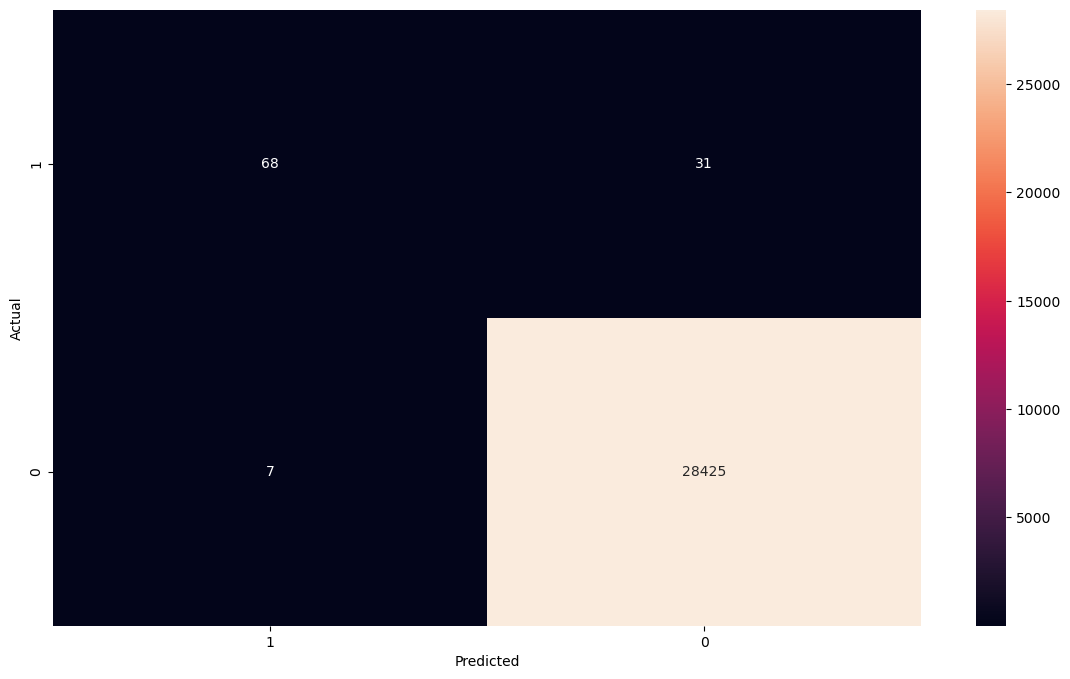

In [43]:
conf_matrix_sklr_model = confusion_matrix(y_test, preds_sklr_model)
ax = sns.heatmap(conf_matrix_sklr_model, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')

This is what a confusion matrix looks like. The y-axis consists of the true labels (Actual), while the x-axis consists of predicted labels (Predicted). 

You may notice that we have inverted the axes in the code "(y_test,preds_sklr_model)" instead of (x,y) or "(preds_sklr_model,y_test)". This is simply to get it in the format so that the top left of the matrix corresponds to “true positives”(Actual), the top right of the matrix corresponds to **“False Negatives”**; the bottom left of the matrix corresponds to **“False Positives”**,and the bottom right of the matrix corresponds to **“True Negatives”**. The top left are **"True Positives"**.

When the true label is “0” and the model predicts “0,” we call this a **true negative**.
“True” refers to the true label, and “negative” refers to the label the model predicts.

<span style='background:lightblue'>What counts as “positive” and what counts as “negative” can differ. In tasks such as disease detection, if a test finds someone to have the disease, they are said to “test positive.” Otherwise, they “test negative.” </span>

Anomaly detection is similar. When a model thinks that a point is an anomaly, it flags it with the label “1.” And so, a point is labeled “positive” if the model thinks it is an anomaly, and “negative” if it doesn’t.


The confusion matrix plot of the results of training. The accuracy for the normal points is very good, but the accuracy for the anomaly points is ok. There is still further room for improvement looking at these results, as we have not tuned the hyperparameters of the model yet, but it already does ok in detecting anomalies. 

The goal now is to keep the accuracy for the normal points as high as possible, or at a high enough level that’s acceptable, while raising the accuracy for the anomaly points as high as possible. Based on this confusion matrix plot, you can now see that the lower AUC score is more accurate at reflecting the true performance of the model. You can see that a non-negligible amount of anomalies were falsely classified as normal,<span style='background:lightblue'> hence an AUC score of 0.84 is a much better indicator of the model’s performance than the graph’s apparent score of 0.98</span>

A quic recap of confusion matrix cuadrans:
1. True Positives are values that the model predicts as positive that actually are positive.
2. False Negatives are values that the model predicts as negative that actually are positive.
3. False Positives are values that the model predicts as positive that actually are negative.
4. True Negatives are values that the model predicts as negative that actually are negative.

Text(0.5, 58.7222222222222, 'Predicted')

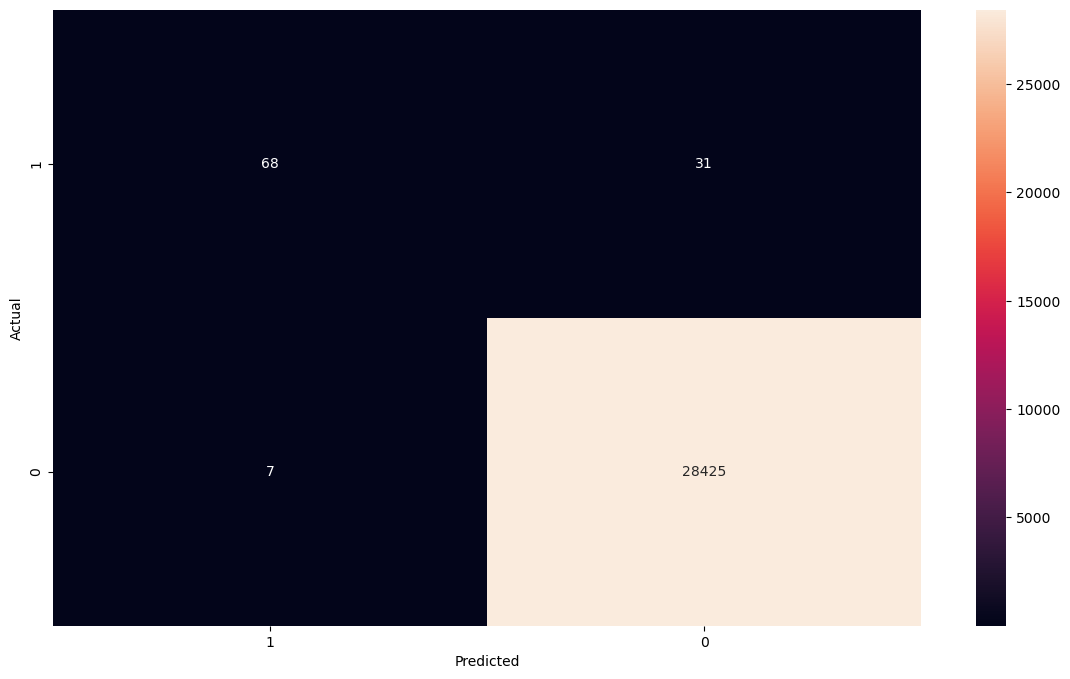

In [44]:
conf_matrix_sklr_model = confusion_matrix(y_test, preds_sklr_model)
ax = sns.heatmap(conf_matrix_sklr_model, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')

To look at how well the model identifies anomalies, look at the 1 row on the y-axis. The sum of this row should equal the total number of anomalies in the test set: 99 anomalies.<span style='background:lightblue'>  The model predicted about 68.7% of the anomalies correctly (68/(68+31))</span> and predicted 99.98% of the normal points correctly (28425/(28425 + 7)) looking at the bottom row.

As you can see, the confusion matrix gives us a really good look at the true performance of the model. You now know that it does very well in the task of predicting normal points but does an ok job at predicting anomalies. That being said, the model can still predict a majority of anomalies correctly. And so you can see that the AUC score of 0.84 was much more accurate at indicating the performance of the model than the graph, which had an AUC of 0.98. With an AUC of 0.98, you can expect that there are very, very few instances of false negatives or false positives.

[Return to Contents of credit card dataset analysis](#1lrskl)

<a id='7lrskl'></a>
### 7 Model Validation

The fifth phase in the CRISP-DM process takes place once we have the final models from the modeling phase that satisfy necessary success criteria with respect to our data mining goals and have the desired performance and results with regard to model evaluation metrics like accuracy.

The evaluation phase involves carrying out a detailed assessment and review of the final models and the results which are obtained from them. Some of the main points that are evaluated in this section are as follows.

1. Ranking final models based on the quality of results and their relevancy based on alignment with business objectives
2. Any assumptions or constraints that were invalidated by the models
3. Cost of deployment of the entire Machine Learning pipeline from data extraction and processing to modeling and predictions
4. Any pain points in the whole process? What should be recommended? What should be avoided?
5. Data sufficiency report based on results
6. Final suggestions, feedback, and recommendations from solutions team and SMEs (subject matter experts) Based on the report formed from these points, after a discussion, the team can decide whether they want to proceed to the next phase of model deployment or a full reiteration is needed, starting from business and data understanding to modeling.

The reason we split our data into training and test sets is that we are interested in measuring how well our model generalizes to new, previously unseen data (Müller and Guido, 2017).

<span style='background:beige'>We are **not interested** in how well our model fit the training set,</span> but rather in <span style='background:lightblue'> how well it can make predictions for data that was not observed during training.</span>(idem)

The **cross-validation** is a more robust way to assess **generalization performance** with methods to evaluate classification and regression performance that go beyond the default **measures of accuracy and R^2 provided by the score method**.

<a id='71lrskl'></a>
#### Cross-validation from (Müller and Guido, 2017)
Cross-validation is a statistical method of **evaluating generalization performance** that is more stable and thorough than using a split into a training and a test set. 

<span style='background:lightblue'>In crossvalidation, **the data is instead split repeatedly** and **multiple models are trained**.</span>

The most commonly used version of cross-validation is **k-fold cross-validation**, where k is a user-specified number, usually 5 or 10.

When performing five-fold cross-validation, the data is first partitioned into five parts of (approximately) equal size, called **folds**. Next, a sequence of models is trained. 

The first model is trained using the first fold as the test set, and the remaining folds (2–5) are used as the training set.The model is built using the data in folds 2–5, and then the accuracy is evaluated on fold 1.

Then another model is built, this time using fold 2 as the test set and the data in folds 1, 3, 4, and 5 as the training set. This process is repeated using folds 3, 4, and 5 as test sets.

For each of these five splits of the data into training and test sets, we compute the accuracy. In the end, we have collected five accuracy values. The process is below illustrated.There is a model per each Split (y axis) or K-Cross Validation iteration.

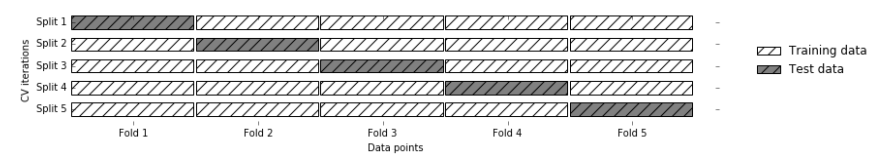

Cross-validation is implemented in scikit-learn using the `cross_val_score` function from the `model_selection` module. The parameters of the `cross_val_score` function are the model we want to evaluate, the training data, and the ground-truth labels (i.e. x,y datasets). In this case we do Cross-validation over our scikit learn logistic regression model `sklr_model`

In [45]:
from sklearn.model_selection import cross_val_score

In [46]:
CVScores = cross_val_score(sklr_model, x_validate, y_validate)
print("Cross-validation scores for sklr_model: {}".format(CVScores))
print("Average cross-validation score: {:.2f}".format(CVScores.mean()))

Cross-validation scores for sklr_model: [0.99859821 0.99894848 0.99842271 0.99824746 0.99877322]
Average cross-validation score: 1.00


As the default is five folds we got 5 scores. These scores have very little variance in its accuracy. The highest value is for the second model/split. As these scores are very accurate the average socre is the maximum value of 1.

[Return to Contents of credit card dataset analysis](#1lrskl)

<a id='72lrskl'></a>
#### Benefits of Cross-Validation (Müller and Guido, 2017)

There are several benefits to using cross-validation instead of a single split into a training and a test set. First, remember that `train_test_split` performs a random split of the data. Imagine that we are “lucky” when randomly splitting the data, and all examples that are hard to classify end up in the training set. In that case, the test
set will only contain “easy” examples, and our test set accuracy will be unrealistically high.

Conversely, if we are “unlucky,” we might have randomly put all the hard-to classify examples in the test set and consequently obtain an unrealistically low score.

However, when using cross-validation, each example will be in the training set exactly once: each example is in one of the folds, and each fold is the test set once. Therefore, the model needs to generalize well to all of the samples in the dataset for all of the cross-validation scores (and their mean) to be high.

Having multiple splits of the data also provides some information about how sensitive our model is to the selection of the training dataset. 

Another benefit of cross-validation as compared to using a single split of the data is that we use our data more effectively. When using train_test_split, we usually use 75% of the data for training and 25% of the data for evaluation. 

When using five-fold cross-validation, in each iteration we can use four-fifths of the data (80%) to fit the model. When using 10-fold cross-validation, we can use nine-tenths of the data (90%) to fit the model. More data will usually result in more accurate models.

<span style='background:beige'>The main disadvantage of cross-validation is increased computational cost</span>. As we are now training k models instead of a single model, cross-validation will be roughly k-times slower than doing a single split of the data.

<span style='background :lightblue'>It is important to keep in mind that cross-validation is not a way to build a model that can be applied to new data.</span> <span style='background:cyan'>Cross-validation does not return a model.</span> <span style='background :lightgree'> When calling cross_val_score, multiple models are built internally, but **the purpose of cross-validation is only to evaluate how well a given algorithm will generalize when trained on a specific dataset**</span>.

[Return to Contents of credit card dataset analysis](#1lrskl)

Let’s now look at how to use the process of **k-fold cross-validation** to compare several hyperparameter values. After the validation process has ended, you will compare the evaluation metrics to get a better idea of what hyperparameter setting works best.

**The hyperparameter we want to tune is how much we want to weight the anomalies by compared to the normal data points**. By default, both of them are weighted equally. 

Let's remember that in the data analysis program(`CredCardAnomDetect1.ipynb`)  **We saw that V9 through V12 graphs show a clear differentiation between the anomalies and the normal points**

In [47]:
# list of weights to iterate over:
anomaly_weights = [1, 5, 10, 15]
anomaly_weights

[1, 5, 10, 15]

Next, lets define the number of folds and initialize your data fold generator:

In [48]:
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [49]:
#Generate indices to split data into training and test set.
# x_validate has 28531 records and 30 columns or features
# y_validate has 28531 records and 1 column or feature
kfold_splitter=kfold.split(x_validate, y_validate)
print(list(kfold_splitter))

[(array([    0,     1,     2, ..., 28527, 28528, 28530]), array([   14,    15,    17, ..., 28520, 28523, 28529])), (array([    0,     1,     2, ..., 28526, 28527, 28529]), array([    5,    10,    13, ..., 28525, 28528, 28530])), (array([    0,     5,     6, ..., 28528, 28529, 28530]), array([    1,     2,     3, ..., 28518, 28522, 28527])), (array([    0,     1,     2, ..., 28528, 28529, 28530]), array([    7,     9,    12, ..., 28510, 28521, 28526])), (array([    1,     2,     3, ..., 28528, 28529, 28530]), array([    0,     6,    19, ..., 28498, 28505, 28524]))]


What this KFold() function does is that it splits the data passed in into num_folds different partitions (5 per default. Then a total of 10 partitions). A single fold acts as a validation set at a time, while the rest of the folds are used for training. In this context, the “validation fold” is basically what the model will be evaluating on. It is called “validation” since it helps us get an idea of how the model is doing on data it has never seen before.

If you have built deep learning models before, you may know that during the training process, you can split a small portion of the training set aside as a validation set. This lets you know during training if you’re overfitting or not, as decreasing training loss and increasing validation loss would indicate.

Before we run our script, let’s go over what the code does.

We define three empty lists (logs, auc_scores, accuracies).

The logs list will record the results of the `sk_model` given its parametes  `x_validate[test]` and `y_validate[test]`, as well the results of the predictions `preds` given its parameters of `sk_model.predict(x_validate[test])` for each run of anomaly weights `anomaly_weights` and for each of the five folds per `anomaly_weights`.  
auc_scores and accuracies lists are to hold the values for AUC scores and accuracy for each run with the current weight parameter (anomaly_weights and fold number).

The first loop goes over each of the anomaly weights. We set the fold=1 to initiate the fold number per each anomaly_weights round.

The second loop goes over the five fold boundaries that the KFold()
object defines. You set the class_weights dictionary and pass it into the model as a hyperparameter. After the training process, you evaluate as usual. There is a try-except block for the AUC score in the event that the fold generated only has values of one class (so really if it only has normal data and no anomalies).**If the AUC score is -1 for any fold, then you know there was a problem with one of the folds**.

You do save the model, the validation data, and the predictions so that
you can examine the confusion matrix and plot the ROC curve for any run
you like. After the end of the five folds, the script then displays averages
and the best scores.

The output will be truncated when you run this, so don’t forget to
expand it like in the previous chapter to look at all of the runs. Feel free to
explore the output or even change the number of folds but beware of the
results because increasing the number of folds can mean that the number
of anomalies must be spread across even more partitions. In this specific
context, a lower number of folds is likely to be better because you have so
few anomaly points.

When you sift through the output, you can see that the best results
occur when the anomaly weight is set to 10. 

Now lets define the validation script:

In [50]:
'''
# list of weights to iterate over:
anomaly_weights = [1, 5, 10, 15]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)
'''
logs = []
'''
logs list keeps records of the results of the `sk_model` 
given its parametes  `x_validate[test]` and `y_validate[test]`,
as well the results of the predictions `preds` given its
parameters of `sk_model.predict(x_validate[test])` 
for each run of anomaly weights `anomaly_weights` 
and for each of the five folds per `anomaly_weights`. 
'''
# empty dictionary for results
d={'FoldNum':[],"AnomWe":[],"AUC":[],"EvalAcc":[]} 
Folds = []
AnomWeights = []
AUCPerFoldAW = []
AccuPerFoldAW = []

# The first loop goes over each of the anomaly weights.
for f in range(len(anomaly_weights)):
    # We set the fold=1 to initiate the fold number per 
    #each anomaly_weights round.
    fold = 1 
    auc_scores= []
    accuracies = []
  
    for train, test in kfold.split(x_validate, y_validate):
        weight = anomaly_weights[f]
        # set the class_weights dictionary and pass it into the 
        # model as a hyperparameter.
        class_weights= {
            0:1,
            1: weight
            }
        sk_model = LogisticRegression(random_state=None,
                                      max_iter=400,
                                      solver='newton-cg',
                                      class_weight=class_weights).fit(x_validate[train],y_validate[train])
        for h in range(40): 
            eval_acc = sk_model.score(x_validate[test],y_validate[test])
            preds = sk_model.predict(x_validate[test])                        
        try:
            auc_score = roc_auc_score(y_validate[test], preds)
        except:
            auc_score = -1
        
        Folds.append(fold)
        AnomWeights.append(weight)
        AUCPerFoldAW.append(eval_acc)
        AccuPerFoldAW.append(auc_score)
        
        print('---------------', end="")
        print(f"\nfold {fold}\nAnomaly Weight: {weight}")
        print("AUC: {}\neval_acc: {}".format(auc_score, eval_acc))
        accuracies.append(eval_acc)
        auc_scores.append(auc_score)
        log = [sk_model, x_validate[test], y_validate[test], preds]
        logs.append(log)
                        
        fold = fold + 1       
        
d.update({'FoldNum':Folds,
          "AnomWe":AnomWeights,
          "AUC":AUCPerFoldAW,
          "EvalAcc":AccuPerFoldAW})

print("\nAverages: ")
print("AUC: ", np.mean(auc_scores))
print("Accuracy: ", np.mean(accuracies))
print("Best: ")
print("AUC: ", np.max(auc_scores))
print("Accuracy: ", np.max(accuracies))

---------------
fold 1
Anomaly Weight: 1
AUC: 0.8
eval_acc: 0.9985982127212195
---------------
fold 2
Anomaly Weight: 1
AUC: 0.8568790049001132
eval_acc: 0.998422712933754
---------------
fold 3
Anomaly Weight: 1
AUC: 0.8179179195189047
eval_acc: 0.9980722046968104
---------------
fold 4
Anomaly Weight: 1
AUC: 0.8682452129973255
eval_acc: 0.9987732211706976
---------------
fold 5
Anomaly Weight: 1
AUC: 0.8528532875621686
eval_acc: 0.9989484752891693
---------------
fold 1
Anomaly Weight: 5
AUC: 0.8748241603657465
eval_acc: 0.9987734361310671
---------------
fold 2
Anomaly Weight: 5
AUC: 0.9515893956527202
eval_acc: 0.9980722046968104
---------------
fold 3
Anomaly Weight: 5
AUC: 0.9314663169342972
eval_acc: 0.9987732211706976
---------------
fold 4
Anomaly Weight: 5
AUC: 0.8943851628367561
eval_acc: 0.9985979670522257
---------------
fold 5
Anomaly Weight: 5
AUC: 0.8820013855427915
eval_acc: 0.9985979670522257
---------------
fold 1
Anomaly Weight: 10
AUC: 0.9245604009143662
eval_acc: 

In [51]:
d

{'FoldNum': [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
 'AnomWe': [1,
  1,
  1,
  1,
  1,
  5,
  5,
  5,
  5,
  5,
  10,
  10,
  10,
  10,
  10,
  15,
  15,
  15,
  15,
  15],
 'AUC': [0.9985982127212195,
  0.998422712933754,
  0.9980722046968104,
  0.9987732211706976,
  0.9989484752891693,
  0.9987734361310671,
  0.9980722046968104,
  0.9987732211706976,
  0.9985979670522257,
  0.9985979670522257,
  0.9985982127212195,
  0.9977216964598669,
  0.9985979670522257,
  0.998422712933754,
  0.9985979670522257,
  0.9978973190818293,
  0.9973711882229233,
  0.9985979670522257,
  0.997546442341395,
  0.9973711882229233],
 'EvalAcc': [0.8,
  0.8568790049001132,
  0.8179179195189047,
  0.8682452129973255,
  0.8528532875621686,
  0.8748241603657465,
  0.9515893956527202,
  0.9314663169342972,
  0.8943851628367561,
  0.8820013855427915,
  0.9245604009143662,
  0.9751350672194998,
  0.9313783507133262,
  0.8942972430196292,
  0.8820013855427915,
  0.9242087216458591,
  0.97495916

In [52]:
SKCV_LogRegResults = pd.DataFrame(d)
SKCV_LogRegResults

,FoldNum,AnomWe,AUC,EvalAcc
0,1,1,0.998598,0.800000
1,2,1,0.998423,0.856879
2,3,1,0.998072,0.817918
3,4,1,0.998773,0.868245
4,5,1,0.998948,0.852853
5,1,5,0.998773,0.874824
6,2,5,0.998072,0.951589
7,3,5,0.998773,0.931466
8,4,5,0.998598,0.894385
9,5,5,0.998598,0.882001


In [53]:
SKCV_LogRegResults.describe()

,FoldNum,AnomWe,AUC,EvalAcc
count,20.000000,20.000000,20.000000,20.000000
mean,3.000000,7.750000,0.998318,0.897166
std,1.450953,5.398587,0.000494,0.046720
min,1.000000,1.000000,0.997371,0.800000
25%,2.000000,4.000000,0.998028,0.873179
50%,3.000000,7.500000,0.998598,0.894077
75%,4.000000,11.250000,0.998598,0.931378
max,5.000000,15.000000,0.998948,0.975135


<AxesSubplot:xlabel='AnomWe'>

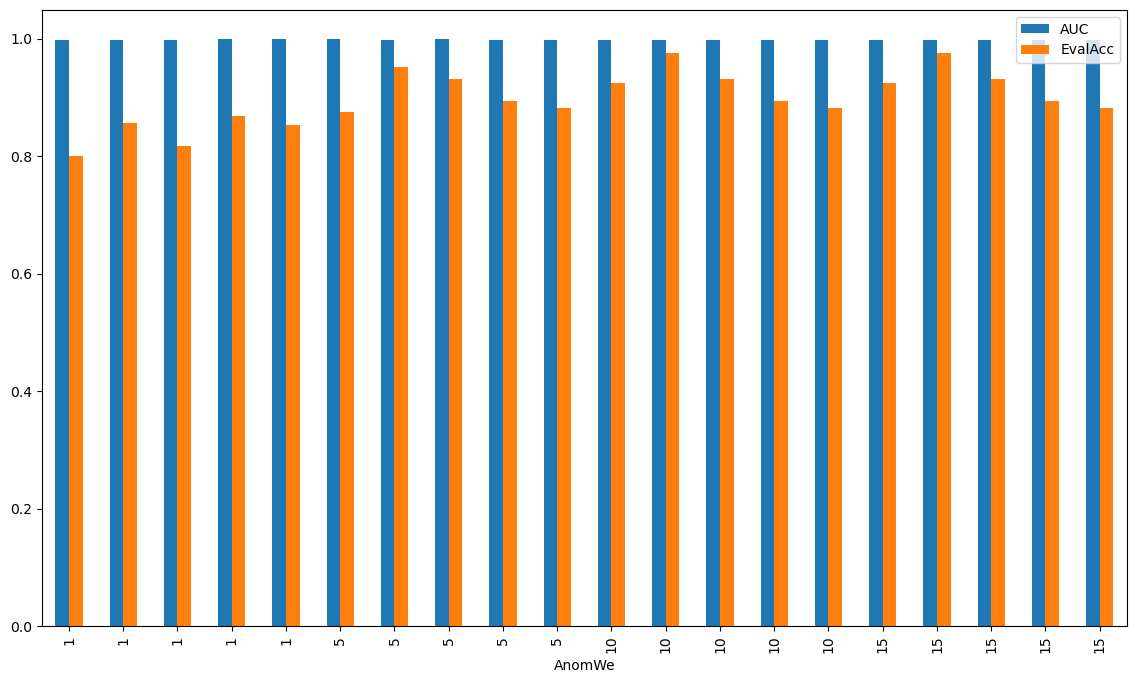

In [54]:
SKCV_LogRegResults.plot(x="AnomWe",y=['AUC','EvalAcc'], kind='bar')

In [55]:
SKCV_LogRegResults.groupby(['AnomWe']).agg({
'AUC': (np.min,np.max,np.average),
'EvalAcc': (np.average,np.min,np.max)})

AUC                       EvalAcc                    
            amin      amax   average   average      amin      amax
AnomWe                                                            
1       0.998072  0.998948  0.998563  0.839179  0.800000  0.868245
5       0.998072  0.998773  0.998563  0.906853  0.874824  0.951589
10      0.997722  0.998598  0.998388  0.921474  0.882001  0.975135
15      0.997371  0.998598  0.997757  0.921158  0.881386  0.974959

While the highest AUC average are for Anomaly Weights 1 and 5, their Accuracies are lower than the accuracy averge for AnomWe=10. So the AUC and EvalAcc for AnomWe=10 seems to be the best even better than for AnomWe=15.

[Return to Contents of credit card dataset analysis](#1lrskl)

<a id='8lrskl'></a>
## Ploting AUC and the Confusion Matrix

Let’s examine the plots for this setup (Anomaly Weight=10)since it was the best performer of all of them on average.
First, you load the correct log in the list of logs. Since the anomaly weight was 10, and the second fold performed the best, you want to look at the twelfth index in the entries in logs. (The first five correspond to indices 0-4, and the next five are indices 5-9. With index 10, you begin the first fold with weight ten, so the second fold is at index 11.)

In [56]:
sk_model, x_val, y_val, preds = logs[11]

Let’s look at the ROC curve. Keep in mind that since there is so little data in the validation set, the AUC score may not be so accurate. Here is the code:

C:\Users\conza\Anaconda3\envs\TFKERAS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


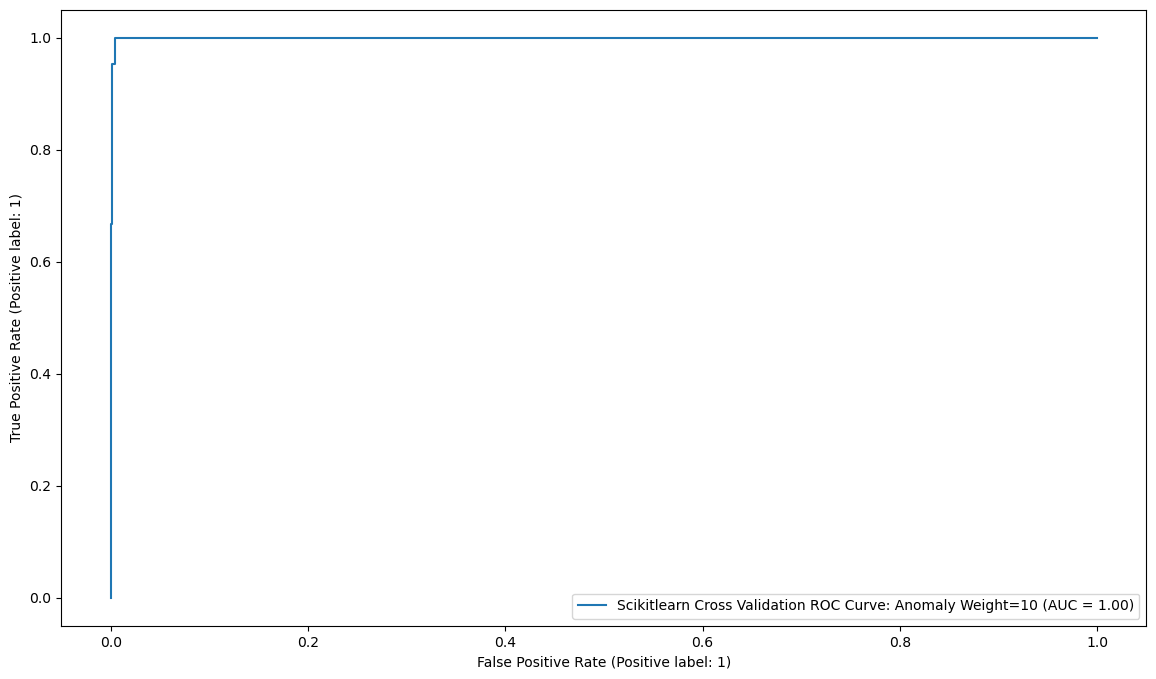

In [58]:
roc_plot = plot_roc_curve(sk_model, x_val, y_val, name='Scikitlearn Cross Validation ROC Curve: Anomaly Weight=10')

Viewing the ROC curve for a specific validation fold, we notice the ROC curve is quite optimal. A perfect ROC curve would start as close as possible to 1.0 on the y-axis while maintaining that level right as it reaches 1.0 on the x-axis. 

An ROC graph like that would mean the AUC would be as close to 1.0 as possible. In this case, you almost see the perfect AUC curve, and the AUC is stated to be 1.0. This graph looks different compared to the ROC plot you saw earlier. In fact, it almost seems perfect.

Let’s look at the confusion matrix to get a better idea of how the model performed on this fold=10:

Text(0.5, 58.7222222222222, 'Predicted')

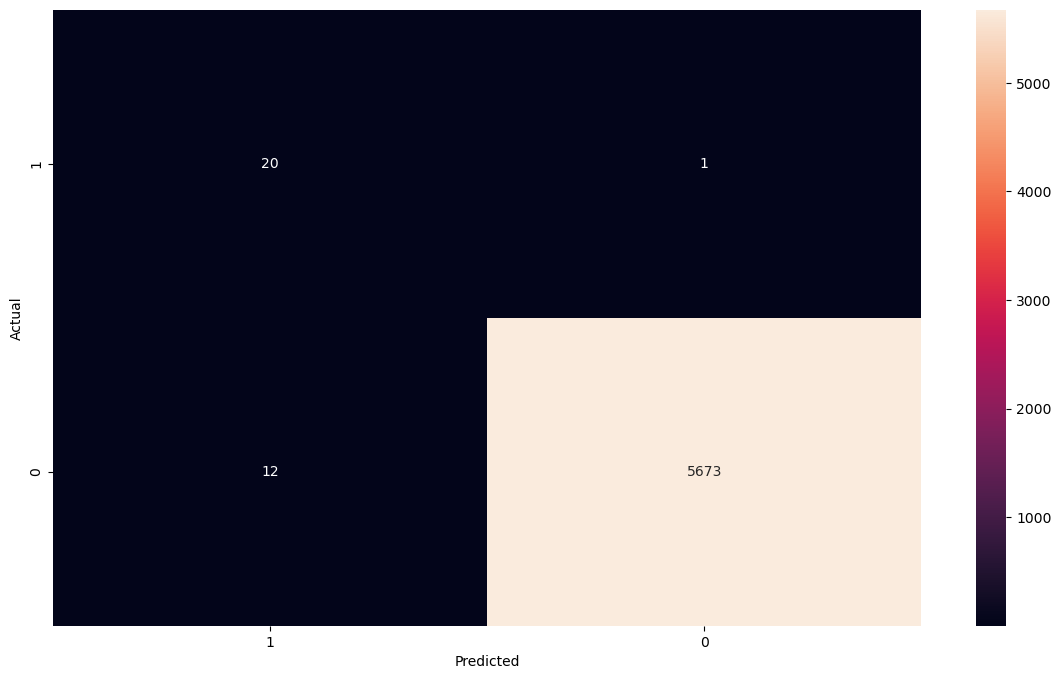

In [59]:
conf_matrix = confusion_matrix(y_val, preds)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')

This confusion matrix for a specific validation fold (Anomaly Weight=10, it has very good accuracy in labeling normal data points (0,0=5673) and does very well with anomaly points(1,1=20). Additionally, you can see that there are barely any anomalies in this validation fold if you count the entries in the top row: 21 anomalies to 5,685 normal points. 

<span style='background:lightgreen'>It is no wonder, then, that having a higher weight on the anomaly helped the model factor in these anomalies in its learning process, resulting in better performance in anomaly detection.</span>

The model did quite well on correctly classifying the anomalies, but
the goal of validation in this case is just to help nudge (para ayudar a empujar) the hyperparameter setting in the right direction. 
<span style='background:lightgreen'>Based on the results of the validation process, you know that the optimal hyperparameter value lies within the values of 10 and 15 because those two settings produced the best results.</span>

Of course, you can narrow the range further to include values between
10 and 15 for the anomaly weights and repeat this process again and again, further reducing the range until a good, optimal value is found. After a certain precision, however, you will find that you are getting diminishing returns, and that the effort you put into hyperparameter tuning only produces near-negligible boosts in performance.

With that, you now know how to train, evaluate, and validate a logistic regression model in scikit-learn.

[Return to Contents of credit card dataset analysis](#1lrskl)

<a id='Reflrskl'></a>
## References

Alla, S., & Adari, S. (2021). Beginning MLOps with MLFlow: Deploy Models in AWS SageMaker, Google Cloud, and Microsoft Azure. Apress.

Gupta, P., & Sehgal, N. (2021). Introduction to Machine Learning in the Cloud with Python: Concepts and Practices. Springer.

Müller, A., & Guido, S. (2017). Introduction to Machine Learning with Python: A Guide for Data Scientists. O’Reilly.

Sarkar, D., Bali, R., & Sharma, T. (2018). Practical Machine Learning with Python: A Problem-Solver’s Guide to Building Real-World Intelligent Systems. Apress.

Verdhan, V. (2020). Supervised Learning with Python: Concepts and Practical Implementation Using Python. Apress.

[Return to Contents of credit card dataset analysis](#1lrskl)